In [1]:
%pip install jira
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn

import pandas as pd
from jira import JIRA
import seaborn as sns
sns.set_theme()

You should consider upgrading via the '/Users/jbanas/.pyenv/versions/3.10.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/jbanas/.pyenv/versions/3.10.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/jbanas/.pyenv/versions/3.10.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/jbanas/.pyenv/versions/3.10.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/jbanas/.pyenv/versions/3.10.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

JIRA_URL = os.getenv("JIRA_URL")
JIRA_API_KEY = os.getenv("JIRA_API_KEY")
JIRA_EMAIL = os.getenv("JIRA_EMAIL")

jira = JIRA(JIRA_URL, basic_auth=(JIRA_EMAIL, JIRA_API_KEY))


In [4]:
STORY_POINTS_FIELD = 'customfield_10004'
FREQUENCY_SEVERITY_FIELD = 'customfield_18774'

issues = jira.search_issues(
    'project=CTOOLS', 
    maxResults=False,
    fields=f'summary,issuetype,description,priority,reporter,{STORY_POINTS_FIELD},{FREQUENCY_SEVERITY_FIELD}'
)

In [22]:
description = lambda issue: issue.fields.summary + '\n' + issue.fields.description if issue.fields.description else issue.fields.summary

df = pd.DataFrame([{
    'key': issue.key,
    'description': description(issue),
    'type': issue.fields.issuetype.name,
    'priority': issue.fields.priority.name,
    'story_points': issue.fields.customfield_10004,
    'frequency': issue.fields.customfield_18774,
    'reporter': issue.fields.reporter.displayName
} for issue in issues])

df.set_index('key', inplace=True)

<Axes: >

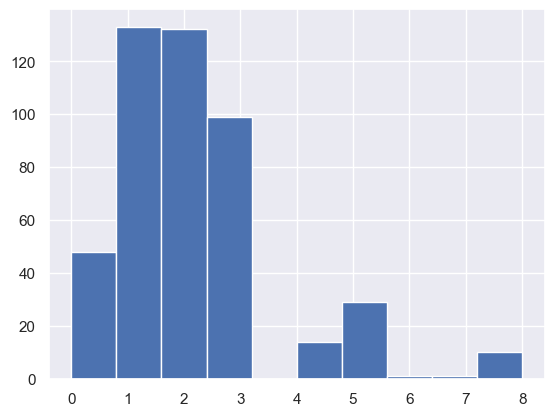

In [23]:
df['story_points'].hist()

/var/folders/hj/s2py2klj33j7glvwd3kyk5200000gp/T/ipykernel_28862/1139394250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined['complexity'] = df_refined['story_points'].apply(lambda x: 'S' if x < 3 else 'M' if x == 3 else 'L')


<Axes: ylabel='count'>

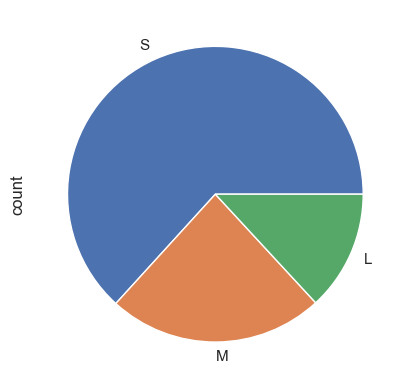

In [24]:
# filter out null story points
df_refined = df[df['story_points'] > 0]

df_refined['complexity'] = df_refined['story_points'].apply(lambda x: 'S' if x < 3 else 'M' if x == 3 else 'L')
df_refined['complexity'].value_counts().plot(kind='pie')

In [25]:
df_refined['complexity'].value_counts()

complexity
S    265
M     99
L     55
Name: count, dtype: int64

In [26]:
# df_refined = (
#     df_refined.groupby('complexity')
#       .sample(n=55, random_state=42)  # Use random_state for reproducibility
# )

# df_refined['complexity'].value_counts()

<Axes: ylabel='count'>

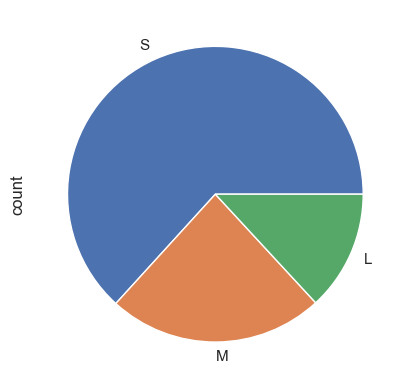

In [27]:
df_refined['complexity'].value_counts().plot(kind='pie')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

In [29]:
X_train, X_test, y_train, y_test =  train_test_split(df_refined['description'], df_refined['complexity'], test_size = 0.3, random_state =0, shuffle = True)

In [30]:
classifier = Pipeline([("tfidf", TfidfVectorizer()) , ("classifier", RandomForestClassifier(n_estimators=100))])
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_test, y_pred

(key
 CTOOLS-784     S
 CTOOLS-880     L
 CTOOLS-1523    S
 CTOOLS-895     S
 CTOOLS-953     S
               ..
 CTOOLS-937     S
 CTOOLS-1034    M
 CTOOLS-749     S
 CTOOLS-1336    S
 CTOOLS-359     S
 Name: complexity, Length: 126, dtype: object,
 array(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
        'S', 'M', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
        'S', 'M', 'S', 'S', 'M', 'S', 'S', 'S', 'S', 'S', 'S', 'M', 'S',
        'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'L',
        'S', 'S', 'S', 'S', 'S', 'S', 'M', 'S', 'S', 'S', 'S', 'S', 'S',
        'M', 'S', 'S', 'S', 'S', 'M', 'M', 'S', 'S', 'S', 'S', 'S', 'S',
        'M', 'S', 'S', 'M', 'M', 'S', 'M', 'S', 'S', 'S', 'S', 'S', 'S',
        'S', 'S', 'M', 'M', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'M', 'S',
        'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
        'S', 'S', 'S', 'S', 'S', 'M', 'S', 'S', 'S'], dtype=object))

In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
accuracy_score(y_test, y_pred)

0.6746031746031746

<Axes: >

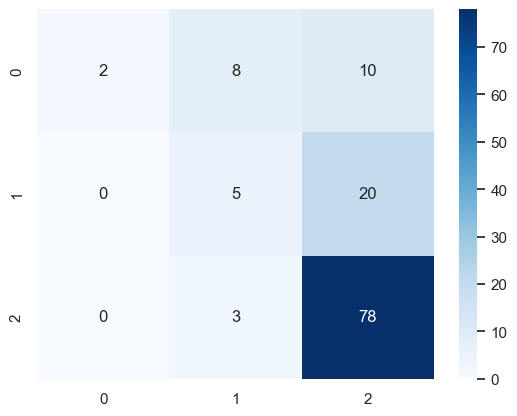

In [32]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           L       1.00      0.10      0.18        20
           M       0.31      0.20      0.24        25
           S       0.72      0.96      0.83        81

    accuracy                           0.67       126
   macro avg       0.68      0.42      0.42       126
weighted avg       0.69      0.67      0.61       126



In [34]:
classifier.predict(["rewrite leaflet feature to the discussions service"])

array(['S'], dtype=object)

In [35]:
# import joblib
# joblib.dump(classifier, 'complexity_classifier.joblib')